In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.0394 - STD: 1.5126e-04 - MAE: 0.1811

 4/64 [>.............................] - ETA: 1s - loss: 0.0222 - STD: 2.6265e-04 - MAE: 0.1168  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0224 - STD: 2.2215e-04 - MAE: 0.1167

10/64 [===>..........................] - ETA: 1s - loss: 0.0205 - STD: 2.0982e-04 - MAE: 0.1096

13/64 [=====>........................] - ETA: 1s - loss: 0.0182 - STD: 2.2343e-04 - MAE: 0.1026

16/64 [======>.......................] - ETA: 1s - loss: 0.0173 - STD: 2.4881e-04 - MAE: 0.1019

19/64 [=======>......................] - ETA: 1s - loss: 0.0163 - STD: 2.7398e-04 - MAE: 0.0998

22/64 [=========>....................] - ETA: 0s - loss: 0.0155 - STD: 2.9208e-04 - MAE: 0.0966

25/64 [==========>...................] - ETA: 0s - loss: 0.0150 - STD: 3.0778e-04 - MAE: 0.0942

28/64 [============>.................] - ETA: 0s - loss: 0.0145 - STD: 3.2689e-04 - MAE: 0.0922

31/64 [=============>................] - ETA: 0s - loss: 0.0141 - STD: 3.5306e-04 - MAE: 0.0908

34/64 [==============>...............] - ETA: 0s - loss: 0.0137 - STD: 3.8409e-04 - MAE: 0.0901

37/64 [================>.............] - ETA: 0s - loss: 0.0134 - STD: 4.1594e-04 - MAE: 0.0894

40/64 [=================>............] - ETA: 0s - loss: 0.0132 - STD: 4.4572e-04 - MAE: 0.0885

43/64 [===================>..........] - ETA: 0s - loss: 0.0129 - STD: 4.7563e-04 - MAE: 0.0876

46/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 5.0914e-04 - MAE: 0.0869

49/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 5.4849e-04 - MAE: 0.0864

52/64 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 5.9383e-04 - MAE: 0.0860

55/64 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 6.4303e-04 - MAE: 0.0855

58/64 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 6.9495e-04 - MAE: 0.0851

61/64 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 7.5169e-04 - MAE: 0.0847

62/64 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 7.7133e-04 - MAE: 0.0846

64/64 [==============================] - 4s 43ms/step - loss: 0.0120 - STD: 8.1600e-04 - MAE: 0.0844 - val_loss: 0.0092 - val_STD: 0.0017 - val_MAE: 0.0762


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0096 - STD: 0.0024 - MAE: 0.0772

 4/64 [>.............................] - ETA: 1s - loss: 0.0098 - STD: 0.0026 - MAE: 0.0783

 7/64 [==>...........................] - ETA: 1s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0777

10/64 [===>..........................] - ETA: 1s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0774

13/64 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0772

16/64 [======>.......................] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0771

19/64 [=======>......................] - ETA: 1s - loss: 0.0096 - STD: 0.0040 - MAE: 0.0770

22/64 [=========>....................] - ETA: 0s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0769

25/64 [==========>...................] - ETA: 0s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0767

28/64 [============>.................] - ETA: 0s - loss: 0.0095 - STD: 0.0054 - MAE: 0.0765

31/64 [=============>................] - ETA: 0s - loss: 0.0095 - STD: 0.0061 - MAE: 0.0765

34/64 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0069 - MAE: 0.0764

37/64 [================>.............] - ETA: 0s - loss: 0.0094 - STD: 0.0078 - MAE: 0.0762

40/64 [=================>............] - ETA: 0s - loss: 0.0093 - STD: 0.0088 - MAE: 0.0760

43/64 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 0.0099 - MAE: 0.0757

46/64 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 0.0110 - MAE: 0.0755

49/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0122 - MAE: 0.0753

52/64 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0135 - MAE: 0.0750

55/64 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0146 - MAE: 0.0748

58/64 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0157 - MAE: 0.0746

61/64 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0168 - MAE: 0.0743

64/64 [==============================] - ETA: 0s - loss: 0.0089 - STD: 0.0177 - MAE: 0.0741

64/64 [==============================] - 2s 26ms/step - loss: 0.0089 - STD: 0.0177 - MAE: 0.0741 - val_loss: 0.0074 - val_STD: 0.0272 - val_MAE: 0.0676


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0077 - STD: 0.0377 - MAE: 0.0686

 4/64 [>.............................] - ETA: 1s - loss: 0.0078 - STD: 0.0385 - MAE: 0.0688

 7/64 [==>...........................] - ETA: 1s - loss: 0.0078 - STD: 0.0388 - MAE: 0.0687

10/64 [===>..........................] - ETA: 1s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0687

13/64 [=====>........................] - ETA: 1s - loss: 0.0078 - STD: 0.0395 - MAE: 0.0686

16/64 [======>.......................] - ETA: 1s - loss: 0.0078 - STD: 0.0399 - MAE: 0.0686

19/64 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.0403 - MAE: 0.0686

22/64 [=========>....................] - ETA: 0s - loss: 0.0078 - STD: 0.0405 - MAE: 0.0686

25/64 [==========>...................] - ETA: 0s - loss: 0.0078 - STD: 0.0407 - MAE: 0.0685

28/64 [============>.................] - ETA: 0s - loss: 0.0078 - STD: 0.0409 - MAE: 0.0684

31/64 [=============>................] - ETA: 0s - loss: 0.0078 - STD: 0.0411 - MAE: 0.0682

34/64 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0413 - MAE: 0.0680

37/64 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0415 - MAE: 0.0679

40/64 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0418 - MAE: 0.0677

43/64 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.0420 - MAE: 0.0675

46/64 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0422 - MAE: 0.0673

49/64 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0424 - MAE: 0.0671

52/64 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0427 - MAE: 0.0668

55/64 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0431 - MAE: 0.0665

58/64 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0436 - MAE: 0.0662

61/64 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0442 - MAE: 0.0659

64/64 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0449 - MAE: 0.0656

64/64 [==============================] - 2s 26ms/step - loss: 0.0073 - STD: 0.0449 - MAE: 0.0656 - val_loss: 0.0057 - val_STD: 0.0495 - val_MAE: 0.0589


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0591

 4/64 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0585

 7/64 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0586

10/64 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0587

13/64 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0584

16/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0584

19/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0582

22/64 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0580

25/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0579

28/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0578

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0609 - MAE: 0.0576

34/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0610 - MAE: 0.0574

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0612 - MAE: 0.0572

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0614 - MAE: 0.0571

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0617 - MAE: 0.0569

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0618 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0568

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0567

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0567

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0567

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0568

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0567

64/64 [==============================] - 2s 26ms/step - loss: 0.0057 - STD: 0.0621 - MAE: 0.0567 - val_loss: 0.0053 - val_STD: 0.0587 - val_MAE: 0.0592


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0616

 4/64 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0619 - MAE: 0.0564

 7/64 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0616 - MAE: 0.0562

10/64 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0559

13/64 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0558

16/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0554

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0551

22/64 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0635 - MAE: 0.0548

25/64 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0547

28/64 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0545

31/64 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0544

34/64 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0542

37/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0540

40/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0539

43/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0538

46/64 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0537

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0536

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0535

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0534

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0533

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0533

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0533

64/64 [==============================] - 2s 26ms/step - loss: 0.0051 - STD: 0.0666 - MAE: 0.0533 - val_loss: 0.0049 - val_STD: 0.0669 - val_MAE: 0.0559


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0579

 4/64 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0694 - MAE: 0.0556

 7/64 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0562

10/64 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0554

13/64 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0650 - MAE: 0.0548

16/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0546

19/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0544

22/64 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0542

25/64 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0539

28/64 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0537

31/64 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0535

34/64 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0533

37/64 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0532

40/64 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0530

43/64 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0529

46/64 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0528

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0527

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0525

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0525

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0525

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0524

64/64 [==============================] - 2s 26ms/step - loss: 0.0050 - STD: 0.0685 - MAE: 0.0524 - val_loss: 0.0044 - val_STD: 0.0594 - val_MAE: 0.0495


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0505

 3/64 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0511

 6/64 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0508

 9/64 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0509

12/64 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0508

15/64 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0507

18/64 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0506

21/64 [========>.....................] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0507

24/64 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0506

27/64 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0506

30/64 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

33/64 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

36/64 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

39/64 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0506

42/64 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0506

45/64 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0506

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0508

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

64/64 [==============================] - 2s 26ms/step - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508 - val_loss: 0.0043 - val_STD: 0.0604 - val_MAE: 0.0488


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0503

 4/64 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0503

 7/64 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0503

10/64 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0503

13/64 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503

16/64 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

19/64 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

40/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

43/64 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

46/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

64/64 [==============================] - 2s 26ms/step - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499 - val_loss: 0.0041 - val_STD: 0.0667 - val_MAE: 0.0488


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0498

 4/64 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

 7/64 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

10/64 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

19/64 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

40/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0498

43/64 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0499

46/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0499

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

64/64 [==============================] - 2s 26ms/step - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499 - val_loss: 0.0040 - val_STD: 0.0647 - val_MAE: 0.0478


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0482

 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0486

 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0486

10/64 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

13/64 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

16/64 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

22/64 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490

25/64 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

28/64 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

31/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

37/64 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0490

40/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

43/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

46/64 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0492

64/64 [==============================] - 2s 26ms/step - loss: 0.0044 - STD: 0.0735 - MAE: 0.0492 - val_loss: 0.0039 - val_STD: 0.0652 - val_MAE: 0.0475


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

 4/64 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0500

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

16/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

22/64 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

28/64 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

31/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

34/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

37/64 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

40/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

43/64 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

46/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

64/64 [==============================] - 2s 26ms/step - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487 - val_loss: 0.0047 - val_STD: 0.0566 - val_MAE: 0.0498


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0510

 4/64 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

28/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

31/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

37/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

40/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0490

43/64 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

46/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

64/64 [==============================] - 2s 26ms/step - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488 - val_loss: 0.0038 - val_STD: 0.0678 - val_MAE: 0.0474


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0480

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

10/64 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

13/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

16/64 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

22/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0480

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

64/64 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480 - val_loss: 0.0037 - val_STD: 0.0679 - val_MAE: 0.0464


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

22/64 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

25/64 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

64/64 [==============================] - 2s 25ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477 - val_loss: 0.0039 - val_STD: 0.0615 - val_MAE: 0.0461


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0472

 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0479

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

19/64 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

22/64 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0477

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

64/64 [==============================] - 2s 25ms/step - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476 - val_loss: 0.0037 - val_STD: 0.0639 - val_MAE: 0.0455


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0462

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0467

10/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0472

13/64 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472

16/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

22/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0472

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

64/64 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0681 - val_MAE: 0.0462


Epoch 17/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0462

 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0468

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0467

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0465

13/64 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0465

19/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

64/64 [==============================] - 2s 26ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464 - val_loss: 0.0036 - val_STD: 0.0669 - val_MAE: 0.0449


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0457

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0459

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

19/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0465

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0466

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

64/64 [==============================] - 2s 25ms/step - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466 - val_loss: 0.0037 - val_STD: 0.0622 - val_MAE: 0.0451


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0462

 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0460

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0461

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0461

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0460

19/64 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

22/64 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

25/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0488

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0490

64/64 [==============================] - 2s 25ms/step - loss: 0.0044 - STD: 0.0739 - MAE: 0.0490 - val_loss: 0.0041 - val_STD: 0.0642 - val_MAE: 0.0505


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0500

 4/64 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0488

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0485

16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0481

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0479

22/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0477

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0476

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0474

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0473

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0471

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0470

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0469

43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0468

46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0467

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0466

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0466

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0465

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0464

64/64 [==============================] - 2s 25ms/step - loss: 0.0039 - STD: 0.0750 - MAE: 0.0464 - val_loss: 0.0035 - val_STD: 0.0691 - val_MAE: 0.0447


Epoch 21/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

19/64 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

64/64 [==============================] - 2s 25ms/step - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452 - val_loss: 0.0035 - val_STD: 0.0709 - val_MAE: 0.0449


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0456

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0681 - val_MAE: 0.0442


Epoch 23/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0450

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0452

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

64/64 [==============================] - 2s 25ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452 - val_loss: 0.0037 - val_STD: 0.0645 - val_MAE: 0.0449


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0448

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0449

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0481

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0760 - MAE: 0.0485

64/64 [==============================] - 2s 25ms/step - loss: 0.0044 - STD: 0.0760 - MAE: 0.0485 - val_loss: 0.0049 - val_STD: 0.0510 - val_MAE: 0.0504


Epoch 25/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0507

 4/64 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0547

 7/64 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0536

10/64 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0534

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0610 - MAE: 0.0524

16/64 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0521

19/64 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0517

22/64 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0632 - MAE: 0.0512

25/64 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0644 - MAE: 0.0508

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0504

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0501

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0497

37/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0495

40/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0491

43/64 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0489

46/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0487

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0483

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0479

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0476

64/64 [==============================] - 2s 25ms/step - loss: 0.0041 - STD: 0.0714 - MAE: 0.0476 - val_loss: 0.0036 - val_STD: 0.0709 - val_MAE: 0.0449


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0449

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0700 - val_MAE: 0.0443


Epoch 27/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

64/64 [==============================] - 2s 25ms/step - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0714 - val_MAE: 0.0446


Epoch 28/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0452

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

64/64 [==============================] - 2s 25ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0723 - val_MAE: 0.0456


Epoch 29/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0811 - MAE: 0.0453

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0445

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

64/64 [==============================] - 2s 25ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0674 - val_MAE: 0.0442


Epoch 30/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0441

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

64/64 [==============================] - 2s 25ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0736 - val_MAE: 0.0456


Epoch 31/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0816 - MAE: 0.0455

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0450

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0459

25/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0466

28/64 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0751 - MAE: 0.0495

31/64 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0511

34/64 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0527

37/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0528

40/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0705 - MAE: 0.0535

43/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0690 - MAE: 0.0535

46/64 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0691 - MAE: 0.0536

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0534

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0535

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0532

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0531

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0528

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0526

64/64 [==============================] - 2s 25ms/step - loss: 0.0050 - STD: 0.0679 - MAE: 0.0526 - val_loss: 0.0041 - val_STD: 0.0574 - val_MAE: 0.0471


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0659 - MAE: 0.0465

 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0467

10/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0466

13/64 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0466

16/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0463

19/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0461

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0459

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0458

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0455

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0454

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0453

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

64/64 [==============================] - 2s 25ms/step - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0685 - val_MAE: 0.0441


Epoch 33/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0440

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

64/64 [==============================] - 2s 25ms/step - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0720 - val_MAE: 0.0445


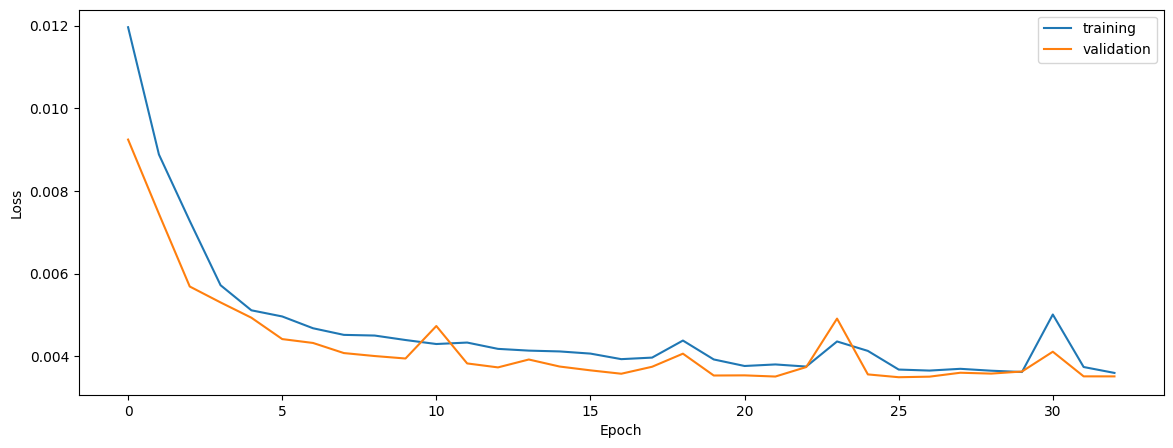

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7952408084801896
0.7932961318639971
0.7904453113782831


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7952408084801896
0.7932961318639971
0.7904453113782831


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7988772201938306
0.793310007857247
0.7962605800911804


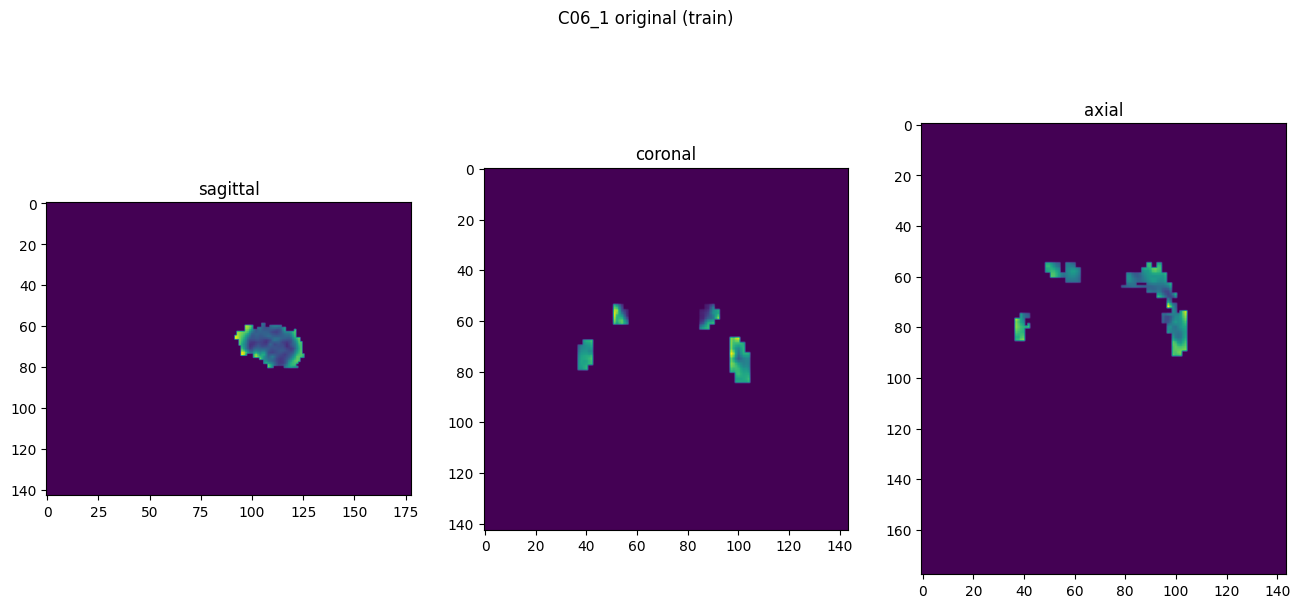

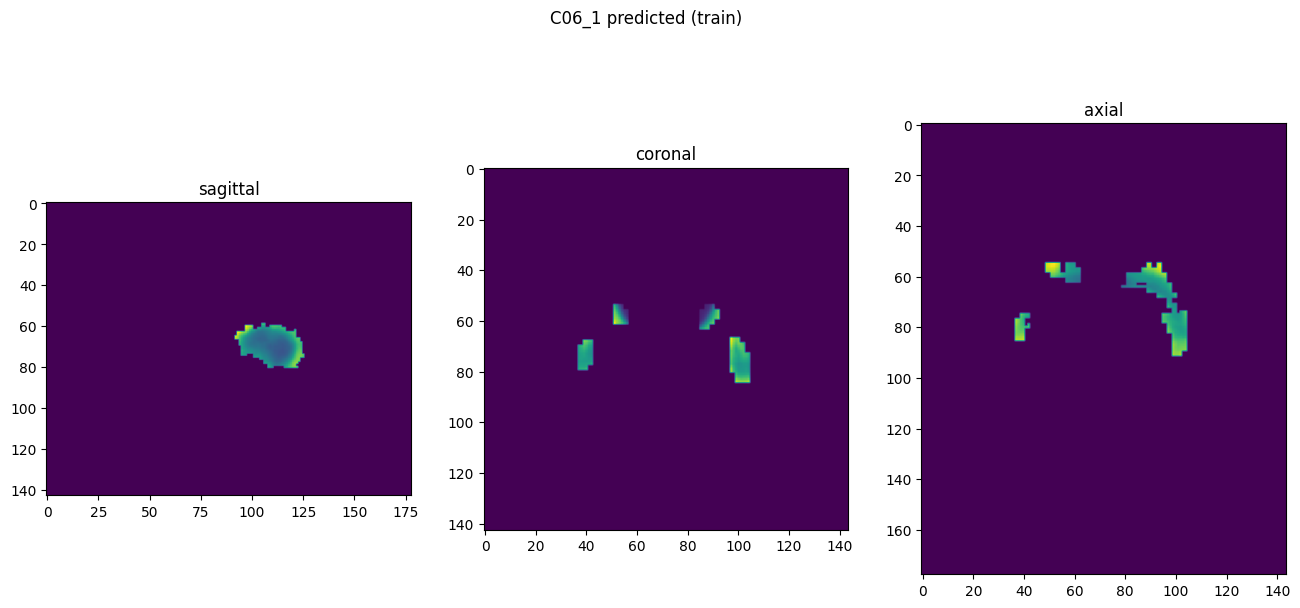

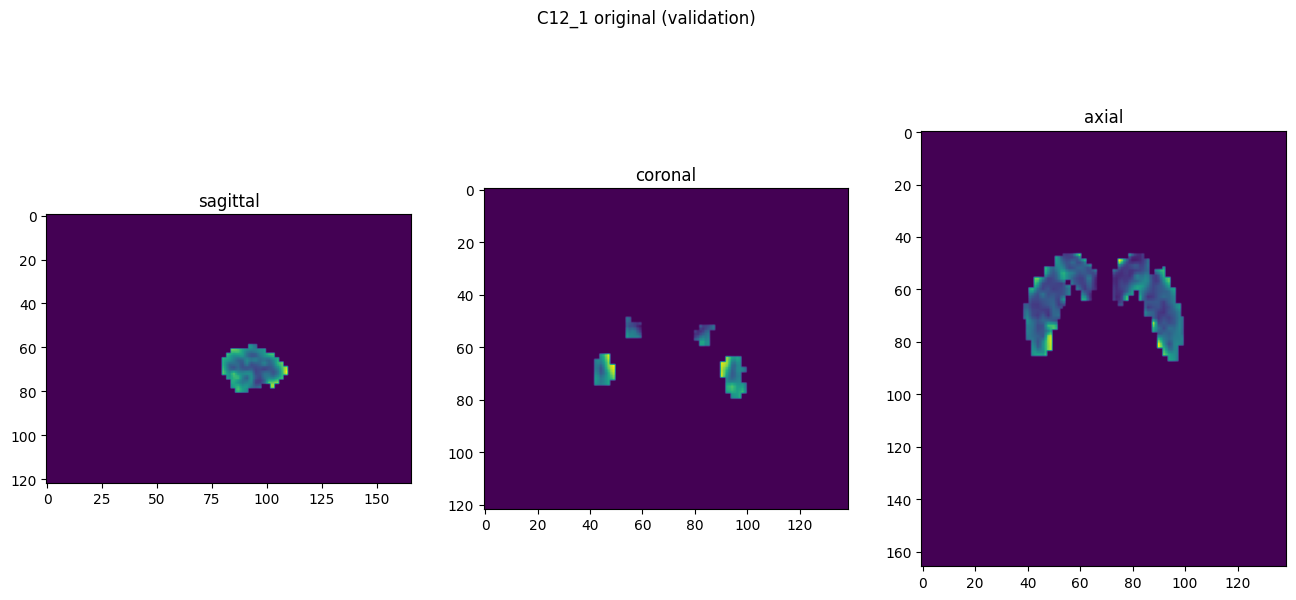

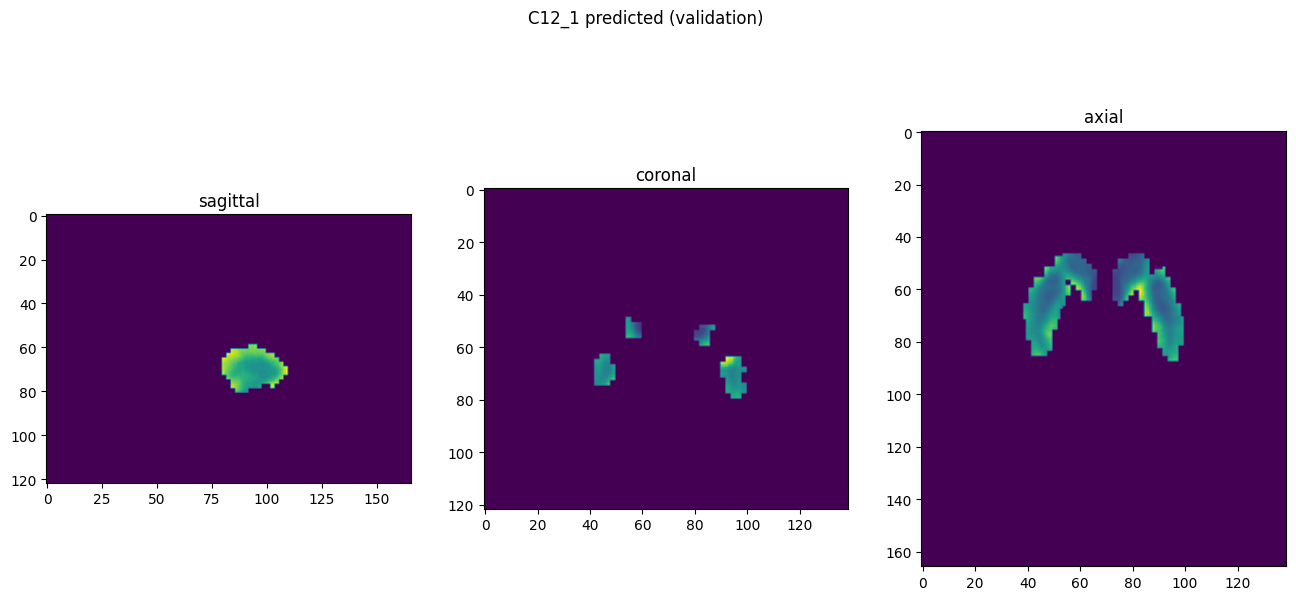

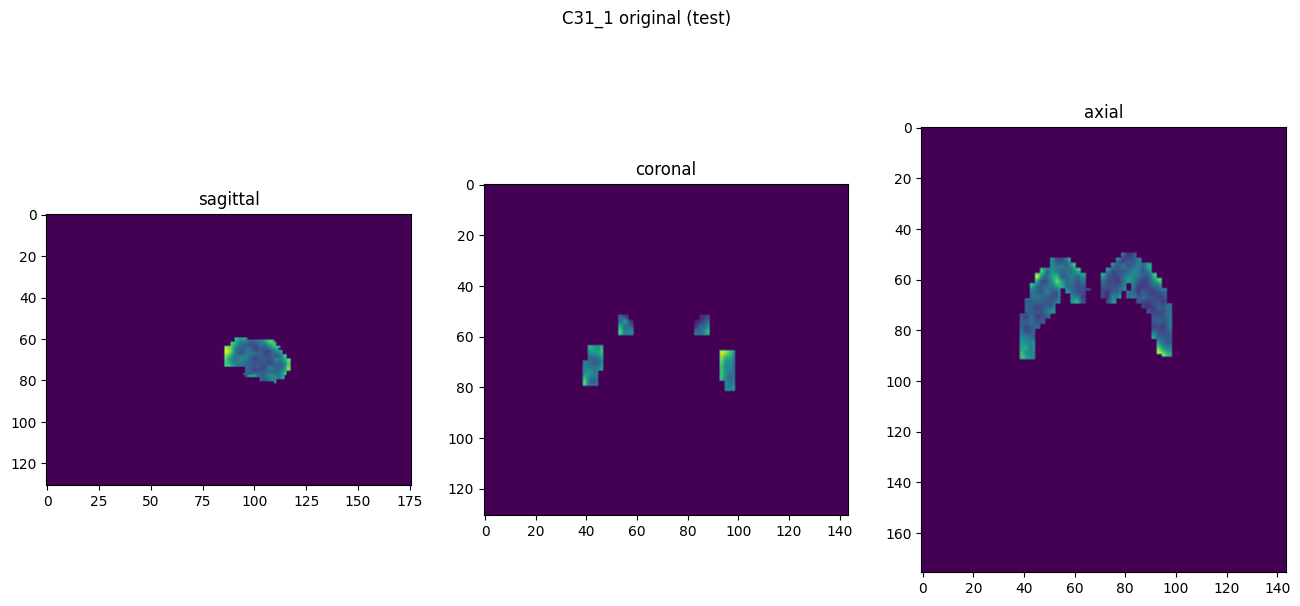

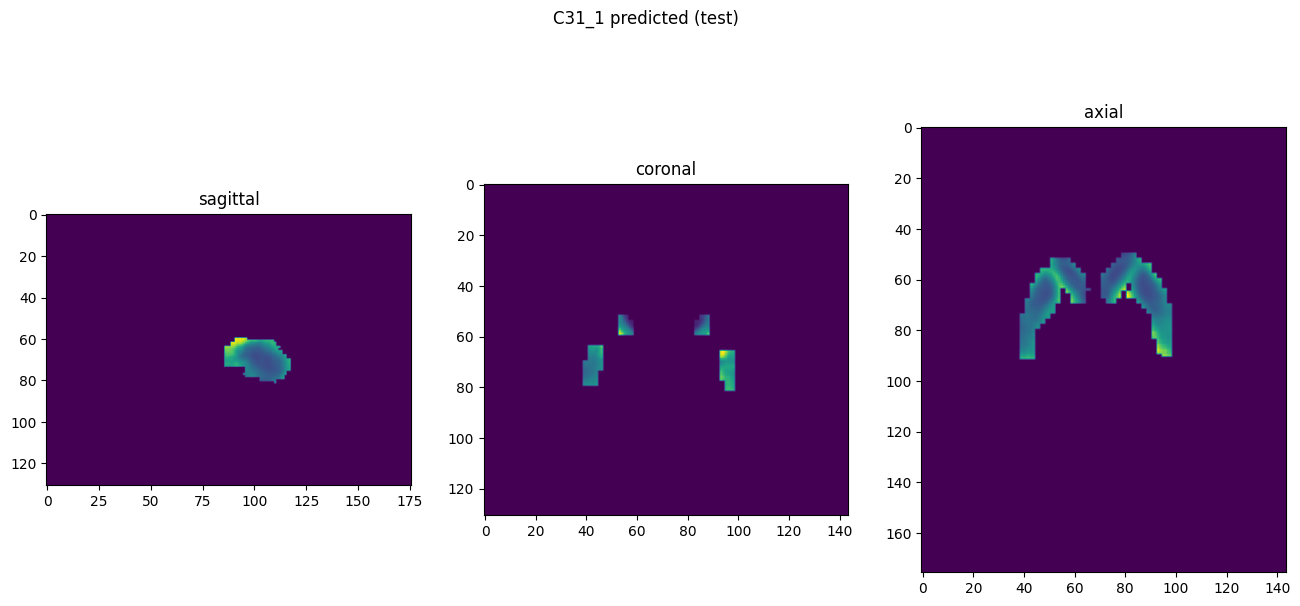

In [10]:
showResults(model, gen, threshold=None, background=False)